In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.metric import MetricCalculator
from data import Reader
from plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from encoder import Encoder
from preparation import DataPreparation, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import Lasso

In [35]:
# Загружаем данные
df = Reader.read_csv('./dataset/df_lowcost.csv')

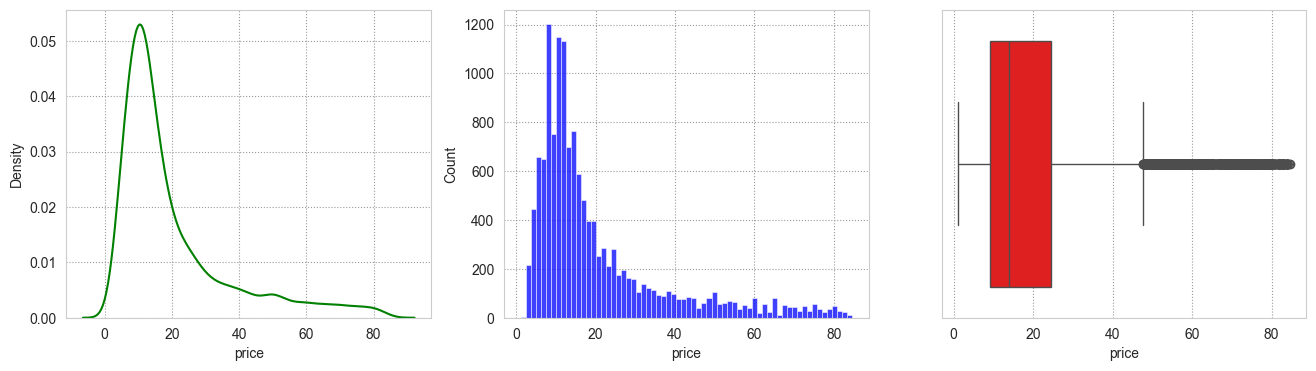

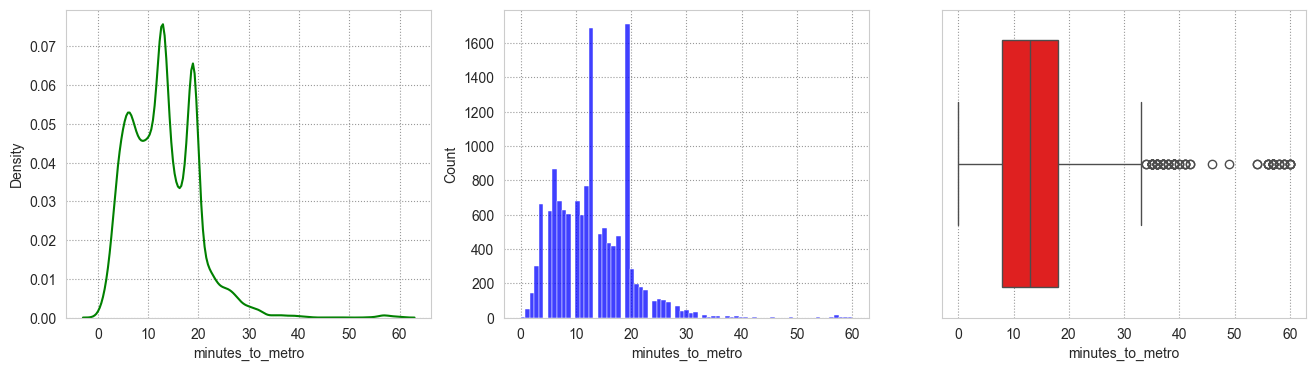

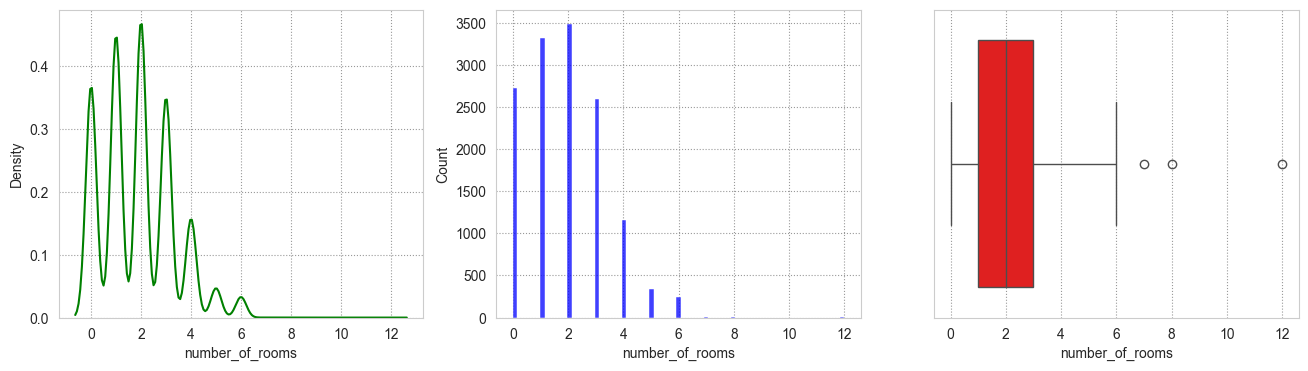

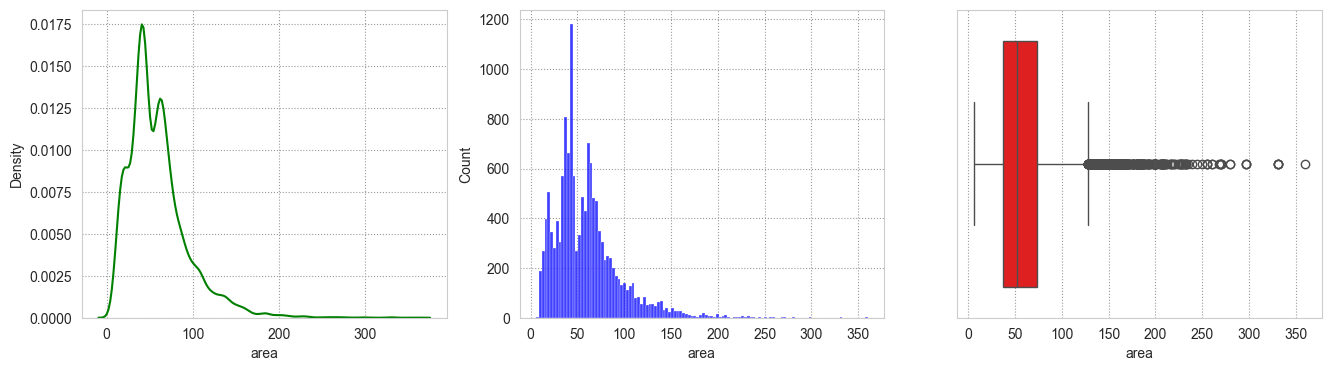

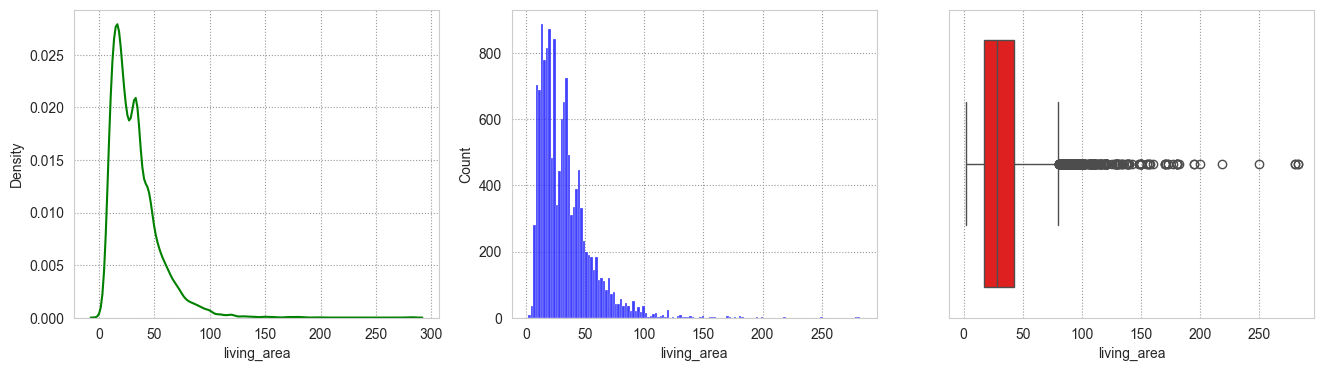

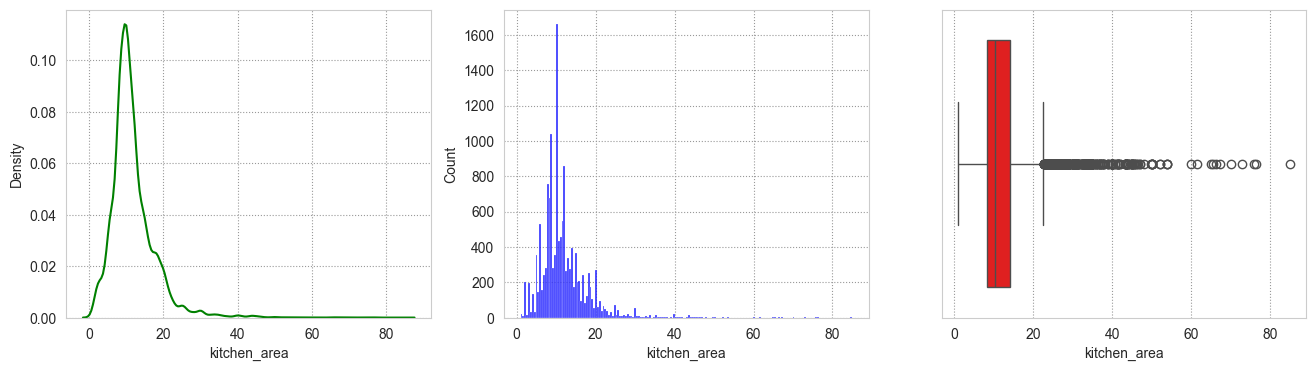

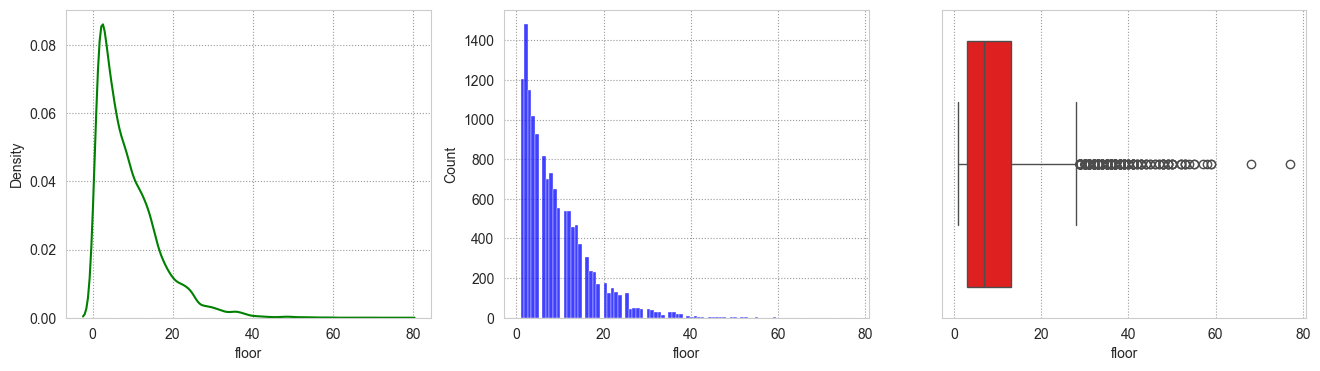

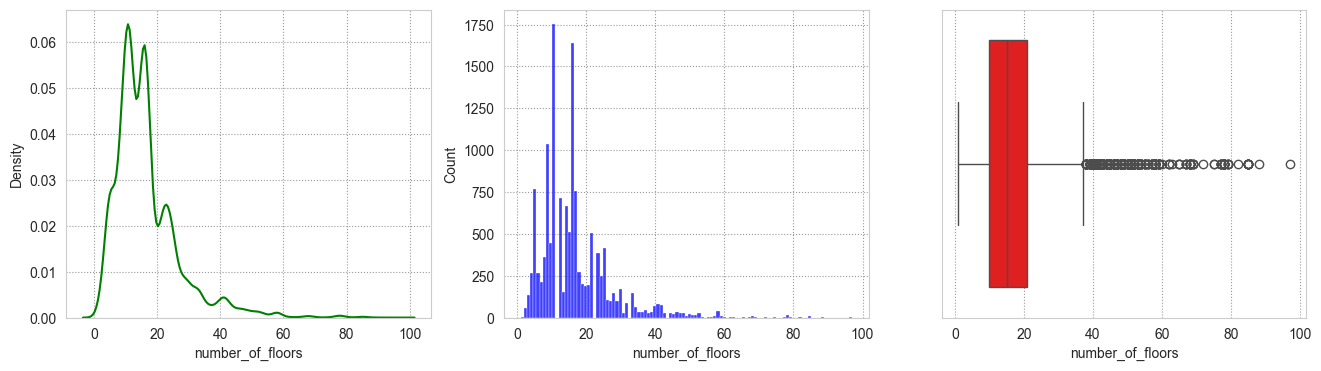

In [36]:
# ещё раз визуально оцениваем обычную недвижимость
Drawer.draw_kde_hist_boxplot(df)

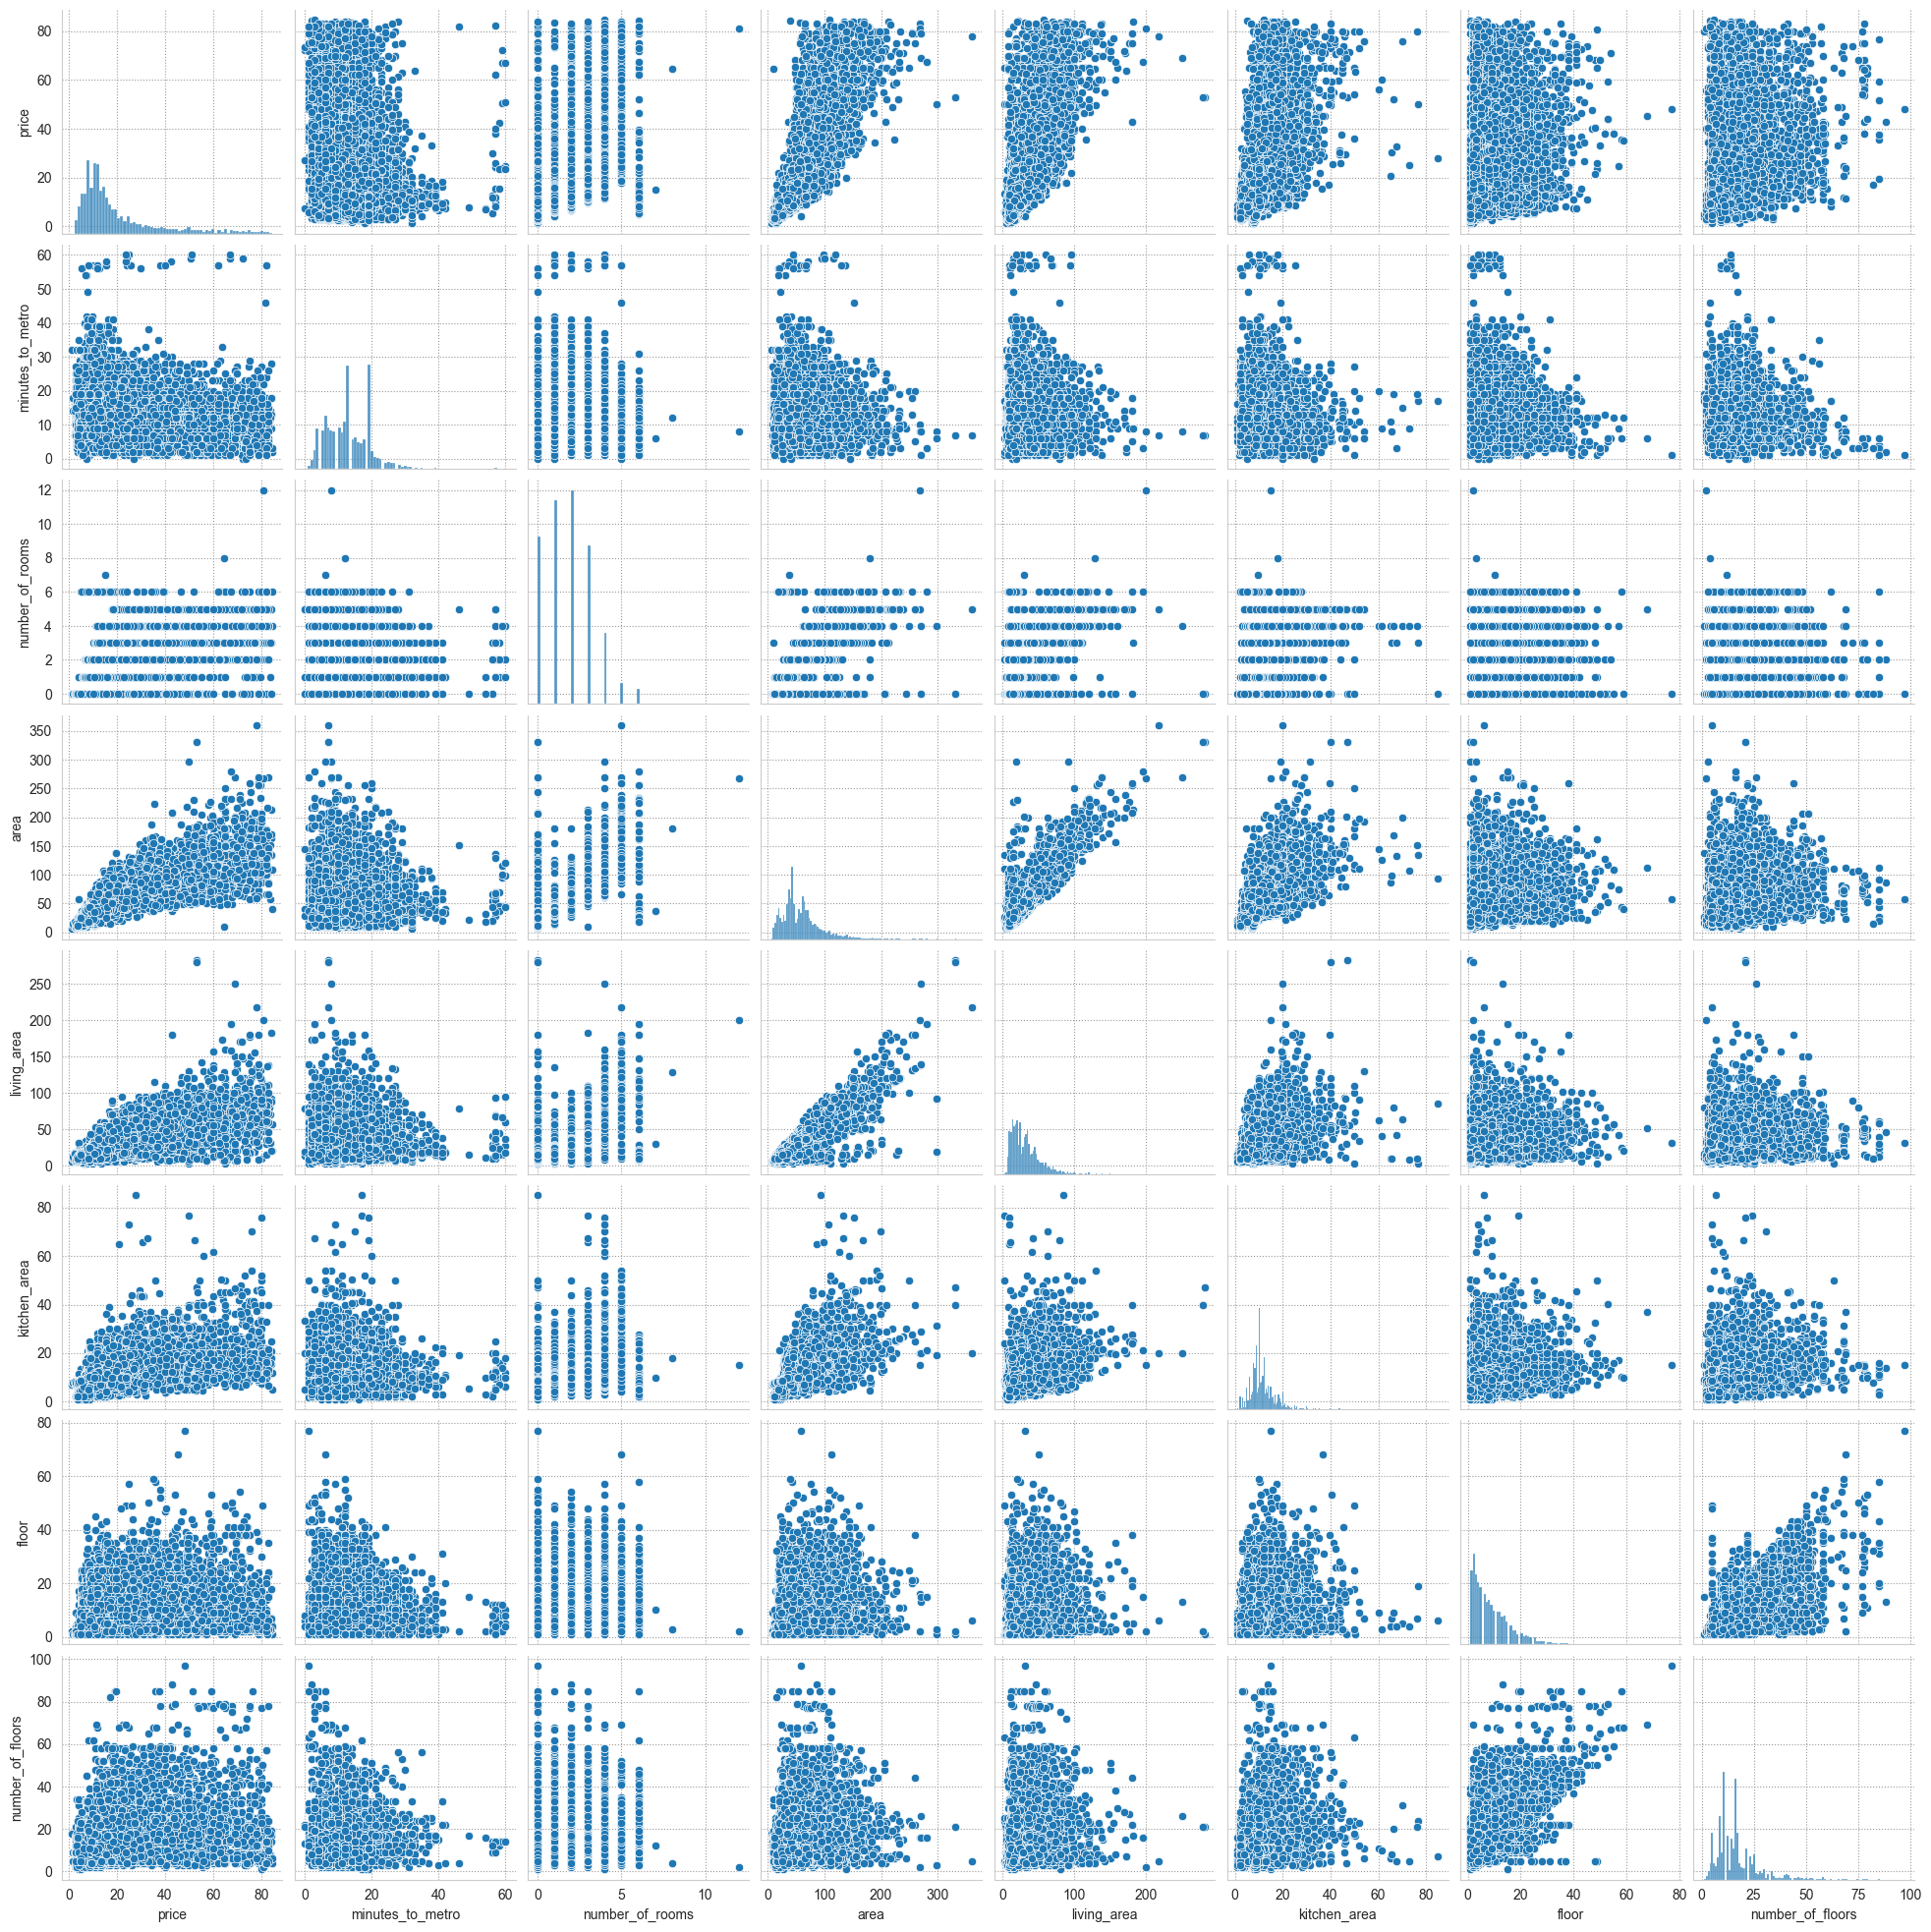

In [37]:
# Исследуем графически зависимость признаков на целевую переменную недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

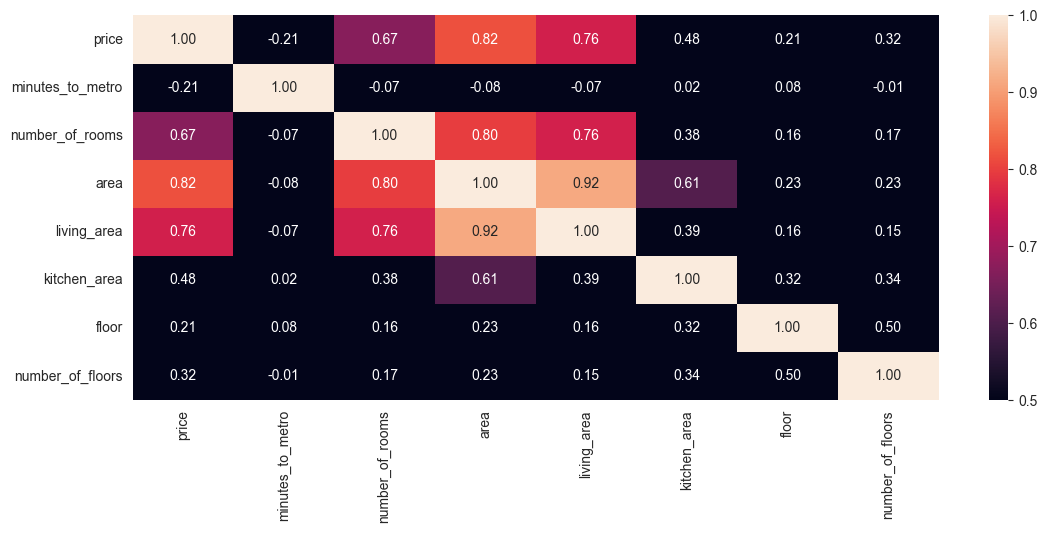

In [38]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

Выводы:
1. графически наблюдается связь цены квартиры от площади.
2. наблюдается корреляция признаков: площадь (area) коррелирует с жилой площадью (living_area) и с площадью кухни (kitchen_area), также числом комнат (number_of_rooms), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF.

In [39]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.962052
number_of_rooms,5.330253
area,40.328189
living_area,23.031125
kitchen_area,8.434223
floor,3.557501
number_of_floors,4.906106


In [40]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.670982
area,3.196631
floor,3.532578
number_of_floors,4.702908


Вывод: для обычной недвижимости четыре признака оказались менее 5, то есть с этими признаками можно работать

In [41]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,13873,13873,13873
unique,2,531,4
top,Secondary,Депо,Cosmetic
freq,10260,1646,6439


Выводы:
1. у нас всего 2 типа аппартаментов в датасете
2. у нас всего 4 вида ремонта в датасете
3. станций метро в москве слишком много (вся россия работает на благоустройство москвы)

In [42]:
StatCriteria().mannwhitneyu(df, 'apartment_type', 'price')

Mann-Whitney U test
U_statistic = 9508570.500
Распределения двух выборок не равны (p-value = 0.000).


(np.float64(9508570.5), np.float64(0.0))

In [43]:
StatCriteria().kruskal(df, 'metro_station', 'price')

kruskal
statistic = 7629.413
Медианы всех групп не равны (p-value = 0.000).


(np.float64(7629.413295552108), np.float64(0.0))

In [44]:
StatCriteria().kruskal(df, 'renovation', 'price')

kruskal
statistic = 3241.754
Медианы всех групп не равны (p-value = 0.000).


(np.float64(3241.753938350835), np.float64(0.0))

Вывод: на стоимость lowcost недвижимости влияют все категориальные переменные такие как:
1. apartment_type,
2. metro_station,
3. renovation

поэтому их все придётся учитывать при проведении регрессии.

In [45]:
df['apartment_type'] = Encoder().booleanOneColumnEncoder(df['apartment_type'], 'Secondary')
df['metro_station'] = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])
df['renovation'] = Encoder().labelEncoder(df['renovation'])

In [46]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,14.259400,0,14.662460,7,2,85.90,41.0,11.4,4,22,0
1,5.477383,1,14.081243,18,6,19.97,9.8,5.1,9,9,0
2,13.500000,1,13.748926,13,3,59.00,40.0,6.0,5,9,0
3,13.000000,1,25.680200,16,2,50.00,30.0,7.0,1,9,3
4,9.900000,1,12.548070,24,1,34.50,15.0,10.8,8,9,2


In [47]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log_norm(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().min_max_scaling(X_train, X_test, y_train, y_test)

In [48]:
# Применяем готовую линейную регрессию из библиотеки statsmodels

# Добавим константу как требование OLS
X_train_plus_const = sm.add_constant(X_train, prepend=False)
X_test_plus_const = sm.add_constant(X_test, prepend=False)

# Обучаем модель на обучающей выборке
model = OLS(y_train, X_train_plus_const).fit()

# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_plus_const)

residuals = y_test.flatten() - y_pred
print(model.summary())

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                 1.517e+04
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:38:59   Log-Likelihood:                 14650.
No. Observations:               10404   AIC:                        -2.929e+04
Df Residuals:                   10397   BIC:                        -2.924e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4190      0.004    105.040      0.0

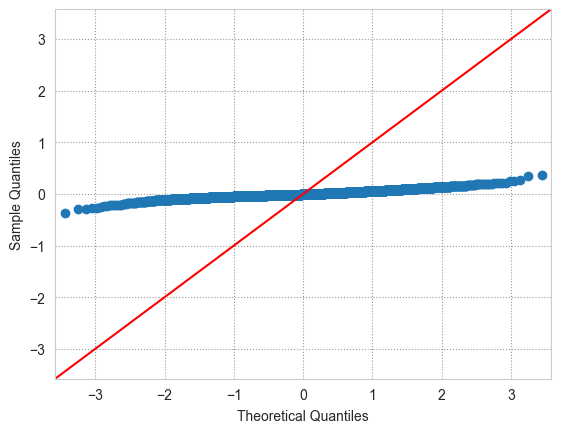

In [49]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

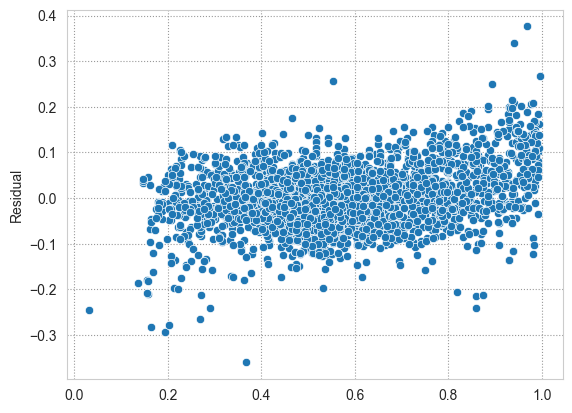

In [50]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.flatten(), y = residuals)
plt.ylabel("Residual")
plt.show()

In [51]:
# Применяем Lasso регрессию
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Прогнозируем на тестовой выборке
y_pred = lasso.predict(X_test)

residuals = y_test.flatten() - y_pred

print("Коэффициенты Lasso-регрессии:", lasso.coef_)

MetricCalculator.show_metrics(y_test, y_pred)

Коэффициенты Lasso-регрессии: [ 0.22917436 -0.          0.45314852  0.          0.          0.05427575]
MAE: 0.07590648237465292
RMSE: 0.09860272541117264
MSE: 0.009722497458511111
MAPE: 36.098509523315066
R²: 0.7213038256827506


Выводы: не влияют minutes_to_metro, floor, number_of_floor